Task 1: Neural Networks & Computer Vision

In [24]:
#Kevin Budzisch
#Western Governors University
#D603: Machine Learning
#Professor Hanan Swidan
#11/11/25

In [25]:
#import libraries as needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

import os
import random
import tensorflow as tf

In [26]:
#Load images from the same folder as the script
imgs = np.load(r"images.npy")
lbls = pd.read_csv(r"labels.csv")

#Now checking the shape to make sure they loaded correctly
print(f"Images shape: {imgs.shape}")
print(f"Labels shape: {lbls.shape}")

Images shape: (4750, 128, 128, 3)
Labels shape: (4750, 1)


B1: Exploratory Data Analysis

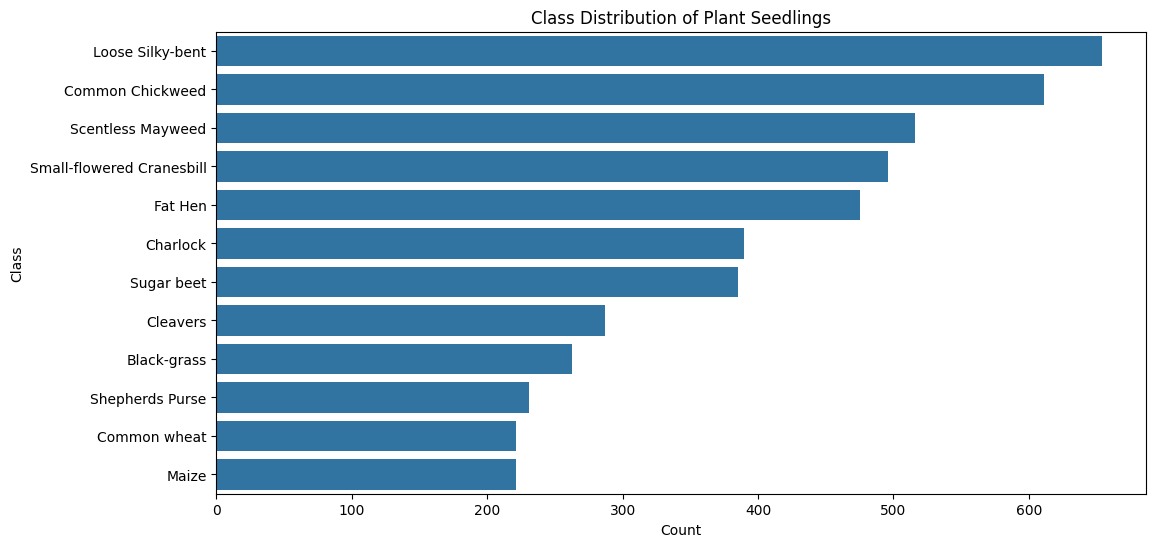

In [27]:
#Creating a visualization for class distribution
plt.figure(figsize=(12, 6))
sns.countplot(y=lbls['Label'], order=lbls['Label'].value_counts().index)
plt.xlabel("Count")
plt.ylabel("Class")
plt.title("Class Distribution of Plant Seedlings")
plt.show()

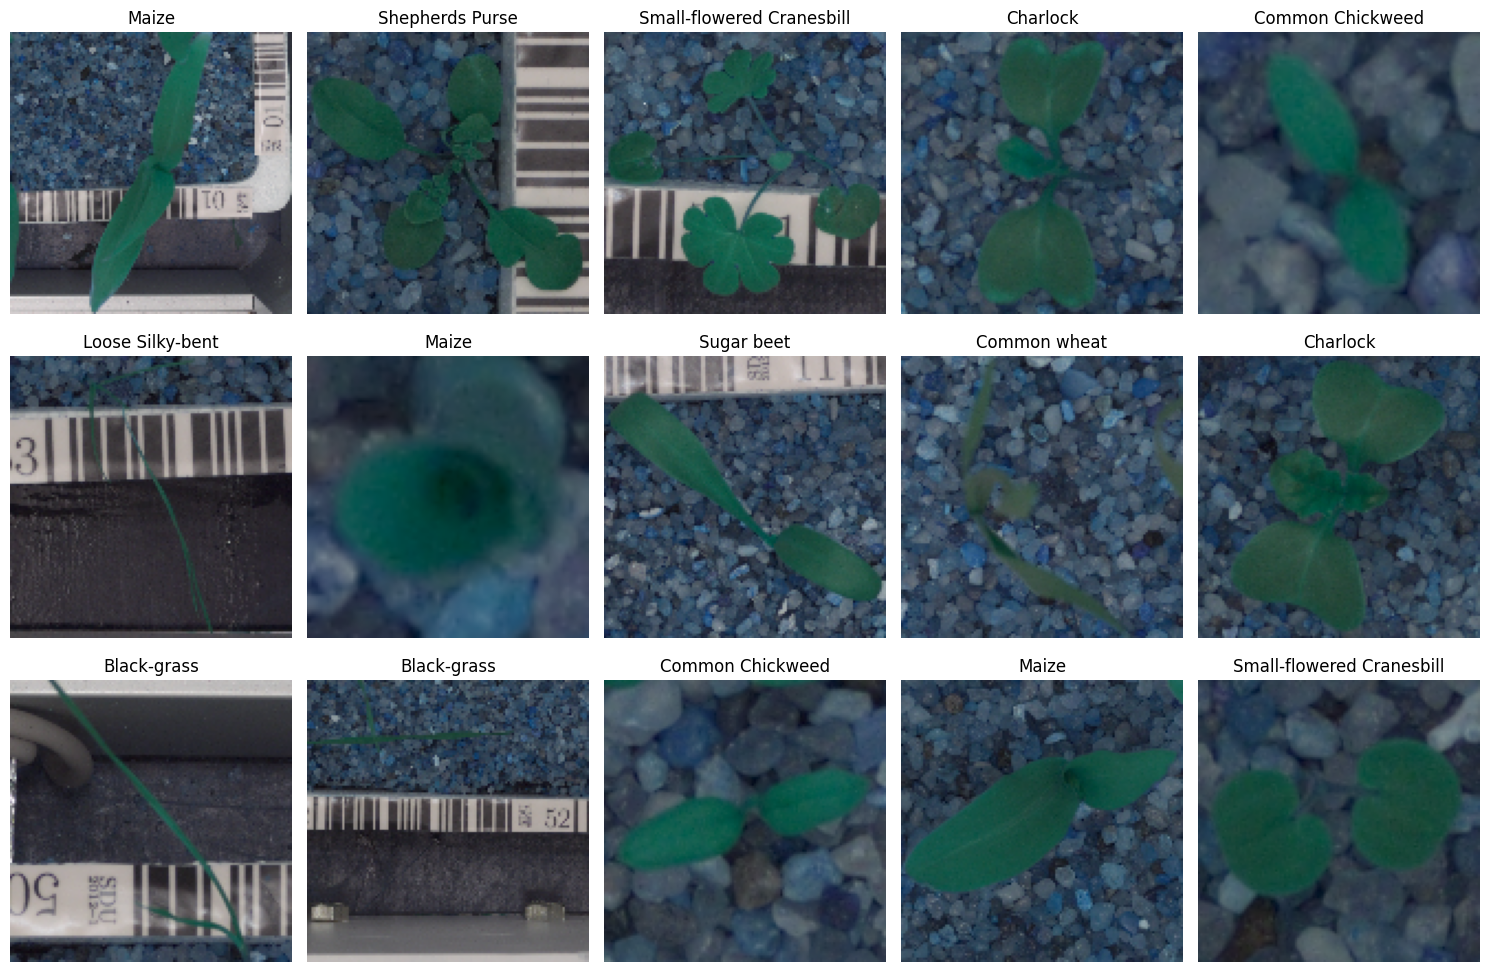

In [28]:
#Displaying 15 random images with labels
num_smpls = 15
indices = np.random.choice(range(imgs.shape[0]), num_smpls, replace=False)
smpl_imgs = imgs[indices]
smpl_lbls = lbls['Label'].iloc[indices].values

#Plotting the samples
plt.figure(figsize=(15, 10))
for i, (img, lbl) in enumerate(zip(smpl_imgs, smpl_lbls)):
    plt.subplot(3, 5, i + 1)
    plt.imshow(img.astype('uint8'))
    plt.title(lbl)
    plt.axis('off')
plt.tight_layout()
plt.show()

B2:Data Preprocessing

In [29]:
#To increase the # of samples in our training set, we can augment the data our data
augment = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    vertical_flip=True,
    fill_mode='nearest'
)

In [30]:
#Now to create our visualizations of augmented images
sample_img = imgs[0].astype('uint8')
sample_img = np.expand_dims(sample_img, axis=0)

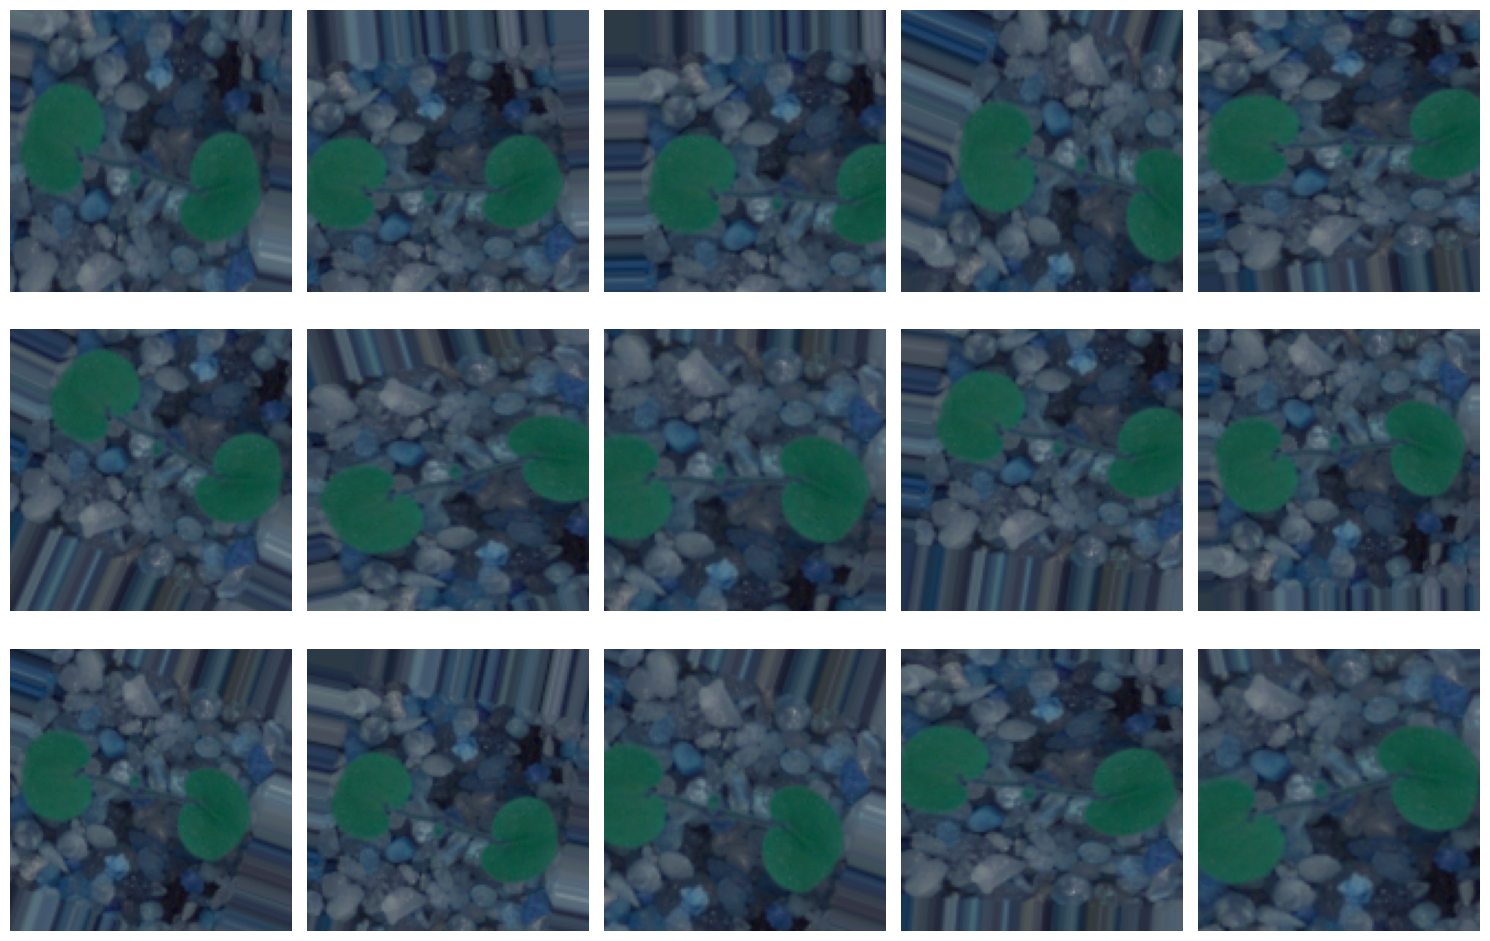

In [31]:

plt.figure(figsize=(15, 10))
for i, augmented in enumerate(augment.flow(sample_img, batch_size=1)):
    if i == 15:
        break
    plt.subplot(3, 5, i + 1)
    plt.imshow(augmented[0].astype('uint8'))
    plt.axis('off')
plt.tight_layout()
plt.show()

In [32]:
#normalize pixel values
imgs = imgs/255.0

In [33]:
#Encoding the labels
lbl_encoder = LabelEncoder()
lbls_encoded = lbl_encoder.fit_transform(lbls['Label'])

In [34]:
#splitting the data in 70/15/15 train, val, test split
x_train, x_temp, y_train, y_temp = train_test_split(imgs, lbls_encoded, test_size=0.3, random_state=1, stratify=lbls_encoded)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=1, stratify=y_temp)

In [35]:
#Target Feature Encoding (One-hot encoding) for tensorflow model
y_val_encoded = to_categorical(y_val)
y_test_encoded = to_categorical(y_test)
y_train_encoded = to_categorical(y_train)

C1. TensorFlow model summary output

In [36]:
#Defining the neural network model
neural_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(lbl_encoder.classes_), activation='softmax')
])

c:\Users\kbudz\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [37]:
#Compiling the model and optimizer
neural_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
neural_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,393,868 (28.21 MB)

 Trainable params: 7,393,868 (28.21 MB)

 Non-trainable params: 0 (0.00 B)

C2. Backpropogation and Hyperparameters

In [38]:
#Early stopping and patience parameters
earlystop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [39]:
##Training the model with class weights to prevent skewed results due to class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(lbls_encoded),
    y=lbls_encoded
)
class_weights_dict = dict(enumerate(class_weights))

history = neural_model.fit(x_train, y_train_encoded, validation_data=(x_val, y_val_encoded),
                    epochs=50, batch_size=32, callbacks=[earlystop],
                    class_weight=class_weights_dict)

Epoch 1/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - accuracy: 0.2135 - loss: 2.1462 - val_accuracy: 0.4199 - val_loss: 1.7102
Epoch 2/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.3826 - loss: 1.7177 - val_accuracy: 0.5492 - val_loss: 1.3885
Epoch 3/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.4571 - loss: 1.4760 - val_accuracy: 0.6180 - val_loss: 1.1842
Epoch 4/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.5311 - loss: 1.3162 - val_accuracy: 0.6306 - val_loss: 1.0944
Epoch 5/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.5696 - loss: 1.1969 - val_accuracy: 0.6390 - val_loss: 1.0520
Epoch 6/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.6159 - loss: 1.1237 - val_accuracy: 0.6404 - val_loss: 1.0141
Epoch 7/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.6466 - loss: 0.9841 - val_accuracy: 0.6896 - val_loss: 0.9518
Epoch 8/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.6629 - loss: 0.9225 - val_accu

C3. Using Commonly Accepted Best Practices



In [40]:
#Setting a fixed random seed to ensure reproducibility.

#Set PYTHONHASHSEED 
os.environ["PYTHONHASHSEED"] = "42"

#Set Python and NumPy random seed
random.seed(42)
np.random.seed(42)

#Set TensorFlow random seed
tf.random.set_seed(42)


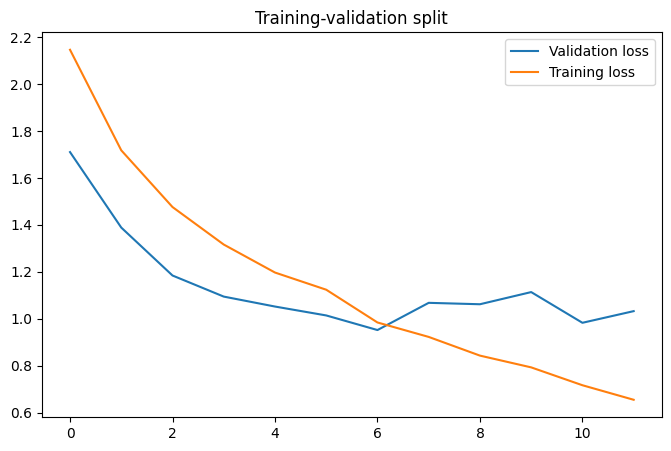

In [41]:
#Training-validation split to evaluate model performance
plt.figure(figsize=(8, 5))
plt.plot(history.history['val_loss'], label='Validation loss')
plt.plot(history.history['loss'], label='Training loss')
plt.title("Training-validation split")
plt.legend()
plt.show()

D1. Evaluate the training and validation process

In [42]:
#Accuracy test calcuation
test_loss, test_acc = neural_model.evaluate(x_test, y_test_encoded)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6760 - loss: 1.0076


D3. Final Predictive Performance


In [43]:
# Generate predicted probabilities
y_pred_probs = neural_model.predict(x_test)

# Predict probabilities
y_pred_probs = neural_model.predict(x_test)

# Convert predictions to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# Convert one-hot encoded test labels to class labels
y_true = np.argmax(y_test_encoded, axis=1)

# Compute metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"\nTest Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")



23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Test Accuracy: 0.6760
Test Precision: 0.6863
Test Recall: 0.6760
Test F1 Score: 0.6744


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


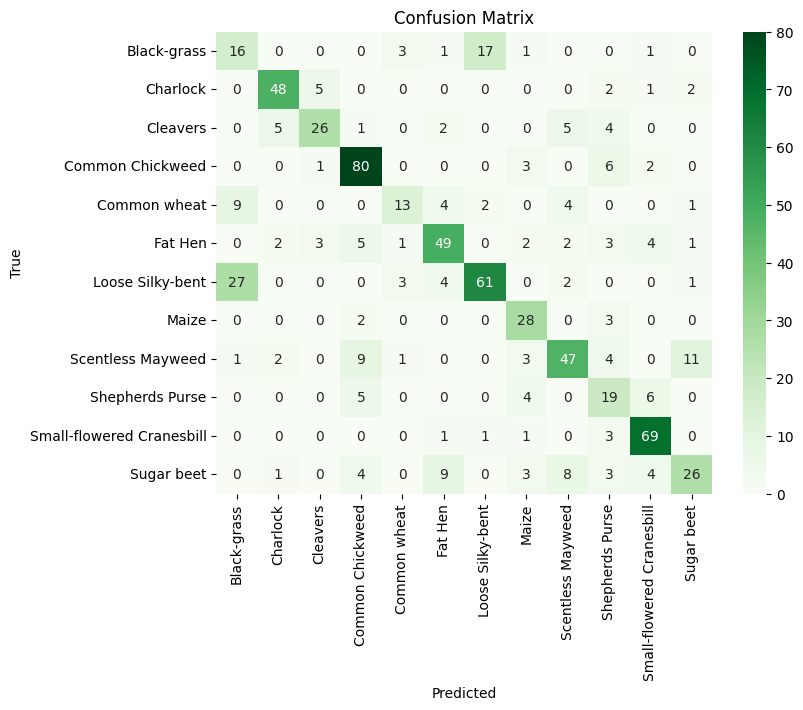

In [53]:
#Creating a heatmap confusion matrix for easier visualization
conf_matr = confusion_matrix(y_test, np.argmax(neural_model.predict(x_test), axis=1))
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matr, annot=True, fmt="d", cmap="Greens", xticklabels=lbl_encoder.classes_, yticklabels=lbl_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
